# `e_above_hull`
This notebook shows some values of `e_above_hull` from Materials Project appear to be different from the ones computed using `get_decomp_and_e_above_hull`.

In [1]:
import pandas as pd
from pymatgen.ext.matproj import MPRester
from pymatgen.analysis.phase_diagram import PhaseDiagram
from pymatgen.core.composition import Composition
from pymatgen.entries.computed_entries import ComputedEntry
import datetime

chemsys=('Li', 'Fe', 'Sb', 'O')
apikey="2d5wyVmhDCpPMAkq"

def download_entries():
    mpr = MPRester(api_key=apikey)
    entries = mpr.get_entries_in_chemsys(
        chemsys, property_data=['e_above_hull', 'formation_energy_per_atom', 'energy_per_atom', 'nsites', 'unit_cell_formula', ]
    )
    records = []
    for e in entries:
        records.append(
            dict(
                normalized_formula=e.composition.fractional_composition.formula,
                formation_energy_per_atom=e.data['formation_energy_per_atom'],
                mpid=e.entry_id,
                e_above_hull=e.data['e_above_hull'],
                energy_per_atom=e.data['energy_per_atom'],
            )
        )
    df = pd.DataFrame.from_records(records)
    df.to_csv("".join(chemsys) + f'-{datetime.datetime.now().strftime("%y-%m-%d")}.csv', index=False)
    return df

df_mp = download_entries()

D:\project\CrystalGraph\venv\lib\site-packages\pymatgen\analysis\phase_diagram.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
D:\project\CrystalGraph\venv\lib\site-packages\pymatgen\ext\matproj.py:179: UserWarning: You are using the legacy MPRester, which is deprecated. If you are not a power user, ie., you do not have a lot of legacy code that uses many different MPRester methods, it is recommended you get a new API key from the new Materials Project front end. Once you use get your new API key, using the new API key will automatically route you to using the new MPRester.
  warnings.warn(


In [2]:
df_mp
# `mp-778012` (row # 191) has a formation energy of `-13.5686` which seems abnormal...

,normalized_formula,formation_energy_per_atom,mpid,e_above_hull,energy_per_atom
0,Fe1,0.054268,mp-1271693,0.054268,-8.415029
1,Fe1,0.097150,mp-136,0.097150,-8.372147
2,Fe1,0.066685,mp-1271562,0.066685,-8.402612
3,Fe1,0.274279,mp-1245108,0.274279,-8.195018
4,Fe1,0.476078,mp-1096950,0.476078,-7.993219
...,...,...,...,...,...
458,Sb1,0.000000,mp-104,0.000000,-4.129000
459,Sb1,0.122997,mp-567409,0.122997,-4.006003
460,Sb1,0.328352,mp-10630,0.328352,-3.800648
461,Sb1,0.234571,mp-1179618,0.234571,-3.894428


In [3]:
def diff_ehull(dataframe: pd.DataFrame, use_formation_energy=True):
    """
    for each entry in the dataframe,
     calculate its `e_above_hull` using the simplex method of pymatgen

    :param dataframe:
    :param use_formation_energy: if use formation energy to calculate `e_above_hull`, otherwise use `energy_per_atom`
    :return: a dataframe contains `e_above_hull` values
    """
    if use_formation_energy:
        energy_key = "formation_energy_per_atom"
    else:
        energy_key = "energy_per_atom"

    computed_entries = []
    for record in dataframe.to_dict(orient="records"):

        ce = ComputedEntry(
            composition=Composition(record["normalized_formula"]),
            energy=record[energy_key],
            entry_id=record["mpid"],
            data={"mp-ehull": record["e_above_hull"]}
        )
        computed_entries.append(ce)

    diagram = PhaseDiagram(computed_entries)
    ehull = []
    for ce in computed_entries:
        decomp, pmg_ehull = diagram.get_decomp_and_e_above_hull(ce)
        mp_ehull = ce.data["mp-ehull"]
        r = dict(
            mpid=ce.entry_id,
            pmg_ehull=pmg_ehull,
            mp_ehull=mp_ehull,
            diff = pmg_ehull - mp_ehull,
        )
        ehull.append(r)
    return pd.DataFrame.from_records(ehull)


df_ehull = diff_ehull(df_mp, use_formation_energy=True)

In [4]:
df_ehull

,mpid,pmg_ehull,mp_ehull,diff
0,mp-1271693,0.054268,0.054268,0.000000e+00
1,mp-136,0.097150,0.097150,0.000000e+00
2,mp-1271562,0.066685,0.066685,0.000000e+00
3,mp-1245108,0.274279,0.274279,5.551115e-17
4,mp-1096950,0.476078,0.476078,0.000000e+00
...,...,...,...,...
458,mp-104,0.000000,0.000000,0.000000e+00
459,mp-567409,0.122997,0.122997,0.000000e+00
460,mp-10630,0.328352,0.328352,0.000000e+00
461,mp-1179618,0.234571,0.234571,2.498002e-16


<AxesSubplot:title={'center':'LiFeSbO 22-11-16'}, xlabel='$\\Delta E_{hull}$ (eV)', ylabel='Count'>

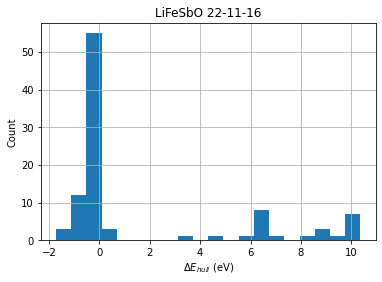

In [5]:
df_nontrivial = df_ehull[df_ehull['diff'].abs() > 1e-3]
hist = df_nontrivial['diff'].hist(bins=20)
hist.set_title("".join(chemsys) + " " + datetime.datetime.now().strftime("%y-%m-%d"))
hist.set_xlabel(r"$\Delta E_{hull}$ (eV)")
hist.set_ylabel("Count")
hist

In [6]:
df_nontrivial

,mpid,pmg_ehull,mp_ehull,diff
5,mp-1194030,0.179693,0.498272,-0.318579
14,mp-18782,0.021580,0.020222,0.001358
16,mp-850511,0.083110,0.768412,-0.685302
17,mp-780312,0.080952,0.258588,-0.177636
24,mp-1178108,0.233380,0.348861,-0.115480
...,...,...,...,...
321,mp-1225001,0.188073,0.445567,-0.257494
324,mp-1182249,0.069054,0.982156,-0.913102
329,mp-601882,0.109962,0.095557,0.014405
338,mp-1184324,0.096736,0.082021,0.014715
